# Computing centralities for inner London


`matplotlib` magic command (only necessary for `jupyter` notebooks).

Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer

## Data and graph cleaning

This example will make use of OSM data downloaded from the [OSM API](https://wiki.openstreetmap.org/wiki/API) for a 5000m radius around London Soho.

For additional information on network preparation, see the corresponding discussion on [graph cleaning](https://cityseer.benchmarkurbanism.com/guide#graph-cleaning).


In [2]:
import utm
from shapely import geometry

from cityseer.tools import graphs, mock

# download from OSM - see docs if you want examples for how to use osmNx for this step
lng, lat = -0.13396079424572427, 51.51371088849723
G_utm = mock.make_buffered_osm_graph(lng, lat, 5000)

/Users/gareth/dev/benchmark-urbanism/cityseer-api/__pypackages__/3.9/lib/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
INFO:cityseer.tools.mock:UTM conversion info: UTM zone number: 30, UTM zone letter: U
INFO:cityseer.tools.graphs:Converting networkX graph from WGS to UTM.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 142772/142772 [00:07<00:00, 18751.52it/s]
INFO:cityseer.tools.graphs:UTM conversion info: UTM zone number: 30, UTM zone letter: U
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 160524/160524 [00:00<00:00, 1079749.53it/s]


<Figure size 432x288 with 0 Axes>

In [3]:
# simplify - this is not necessary if using "clean" graph sources - e.g. OS Open Roads
G = graphs.nx_simple_geoms(G_utm)
G = graphs.nx_remove_filler_nodes(G)
G = graphs.nx_remove_dangling_nodes(G, despine=20, remove_disconnected=True)
G = graphs.nx_remove_filler_nodes(G)
G1 = graphs.nx_consolidate_nodes(G, buffer_dist=10, min_node_group=3)
G2 = graphs.nx_split_opposing_geoms(G1, buffer_dist=15)
G3 = graphs.nx_consolidate_nodes(G2, buffer_dist=15, crawl=False, min_node_degree=2, cent_min_degree=4)

INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 160524/160524 [00:01<00:00, 92604.47it/s] 
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 142772/142772 [00:18<00:00, 7891.94it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 45820/45820 [00:00<00:00, 379455.11it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 41540/41540 [00:00<00:00, 54228.28it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/tools/graphs.py:955: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  point_geom.nd_key = nd_key
/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/tools/graphs.py:956: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  point_geom.degree = nx.degree(n

In [4]:
from cityseer.metrics import networks

# decompose for higher resolution analysis
G_decomp = graphs.nx_decompose(G3, 25)
# calculate centralities
nodes_gdf, network_structure = graphs.network_structure_from_nx(G_decomp, crs=32629)
# this will take around 5 minutes depending on your machine
# if you want to compute wider area centralities, e.g. 20km, then use less decomposition to speed up the computation
nodes_gdf = networks.node_centrality(
    measures=["node_beta", "node_betweenness"],
    network_structure=network_structure,
    nodes_gdf=nodes_gdf,
    distances=[250, 500, 2000],
)

INFO:cityseer.tools.graphs:Decomposing graph to maximum edge lengths of 25.
100%|██████████| 35465/35465 [00:19<00:00, 1859.62it/s]
INFO:cityseer.tools.graphs:Preparing node and edge arrays from networkX graph.
100%|██████████| 90378/90378 [00:21<00:00, 4230.47it/s]
INFO:cityseer.metrics.networks:Computing node_beta, node_betweenness centrality measures using shortest (non-angular) path heuristic.


  0%|          | 0.0/90378 [00:08<?, ?it/s]

/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/algos/centrality.py:353: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  ) = shortest_path_tree(


  0%|          | 35.0/90378 [00:13<10:52, 138.43it/s]

/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/algos/centrality.py:259: NumbaWarning: Cannot cache compiled function "local_node_centrality" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(cache=True, fastmath=config.FASTMATH, nogil=True, parallel=True)


100%|██████████| 90378.0/90378 [06:05<00:00, 247.08it/s]


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale


def simple_plot(xs: np.ndarray, ys: np.ndarray, vals: np.ndarray):
    """ """
    # extents
    easting, northing = utm.from_latlon(lat, lng)[:2]
    buff = geometry.Point(easting, northing).buffer(3500)
    min_x, min_y, max_x, max_y = buff.bounds
    # fig
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, facecolor="white")
    # filter
    select = xs > min_x
    select = np.logical_and(select, xs < max_x)
    select = np.logical_and(select, ys > min_y)
    select = np.logical_and(select, ys < max_y)
    select_idx = np.where(select)[0]
    # remove any extreme outliers
    v = np.clip(vals, np.nanpercentile(vals, 0.01), np.nanpercentile(vals, 99.9))
    # shape if wanted
    c = v**1
    c = minmax_scale(c, feature_range=(0, 1))
    s = v**1.5
    s = minmax_scale(s, feature_range=(0, 1.5))
    # plot
    ax.scatter(
        xs[select_idx], ys[select_idx], c=c[select_idx], s=s[select_idx], linewidths=0, edgecolors="none", cmap="Reds"
    )
    # limits
    ax.set_xlim(left=min_x, right=max_x)
    ax.set_ylim(bottom=min_y, top=max_y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1)
    ax.set_facecolor("white")
    plt.show()


    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 87.57m
    Beta: 0.01600000075995922 (spatial impedance factor)
    Max walking tolerance: 250m
    


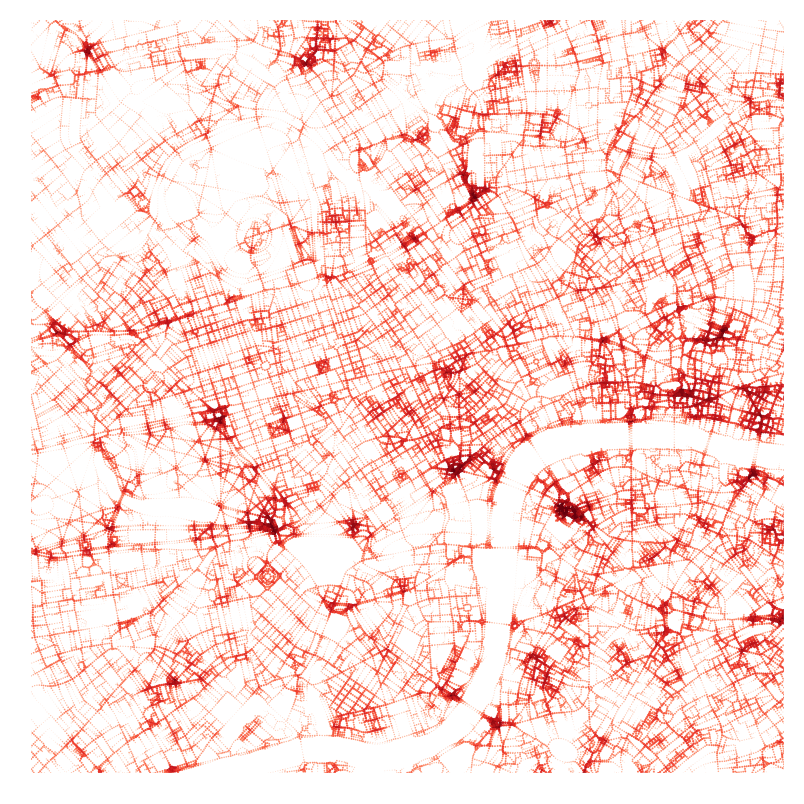


    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 175.37m
    Beta: 0.00800000037997961 (spatial impedance factor)
    Max walking tolerance: 500m
    


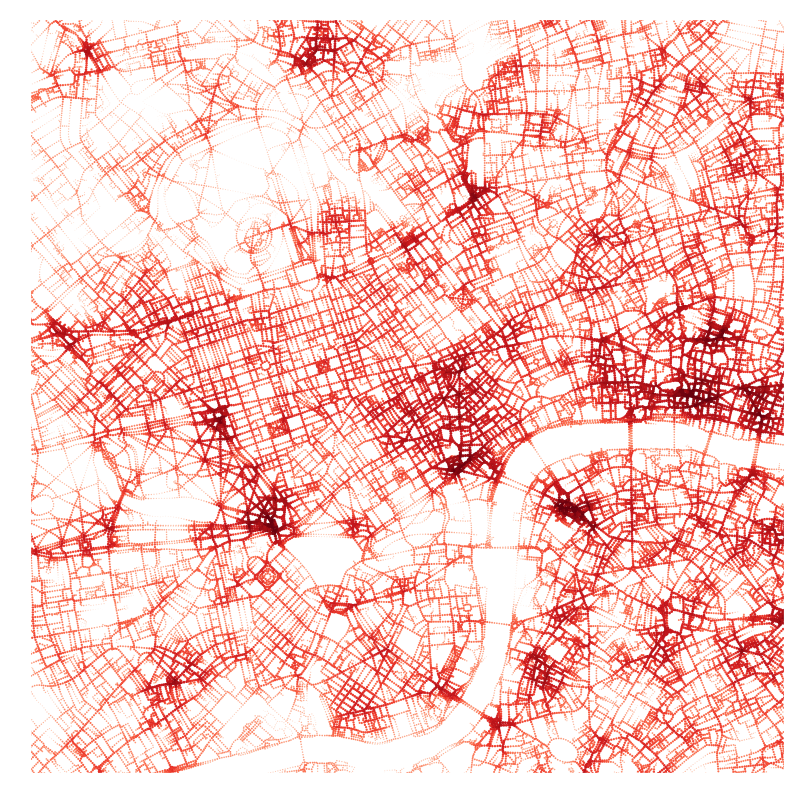


    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 702.16m
    Beta: 0.0020000000949949026 (spatial impedance factor)
    Max walking tolerance: 2000m
    


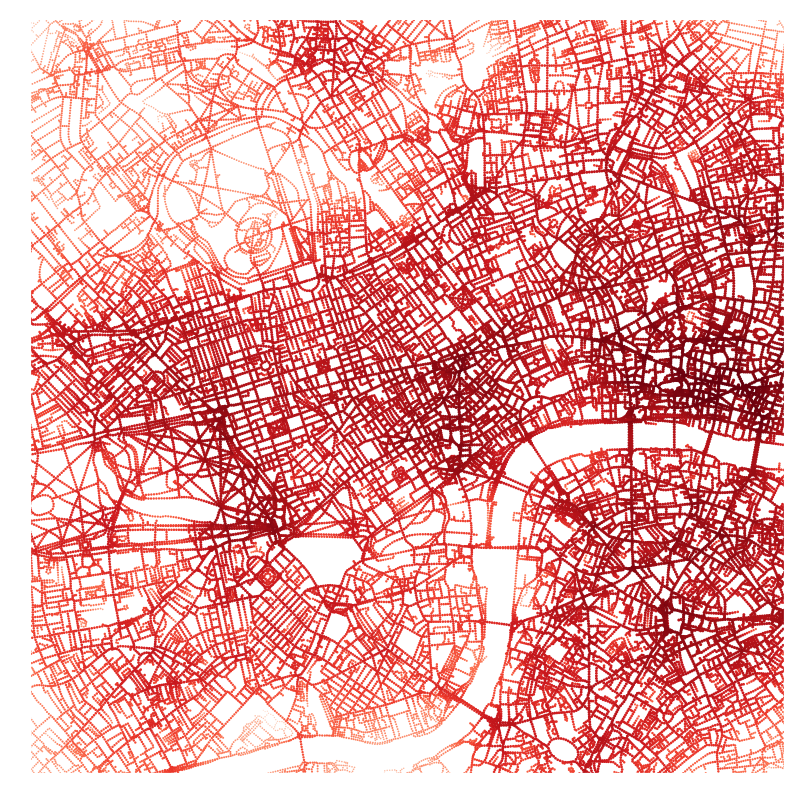


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 702.16m
    Beta: 0.0020000000949949026 (spatial impedance factor)
    Max walking tolerance: 250m
    


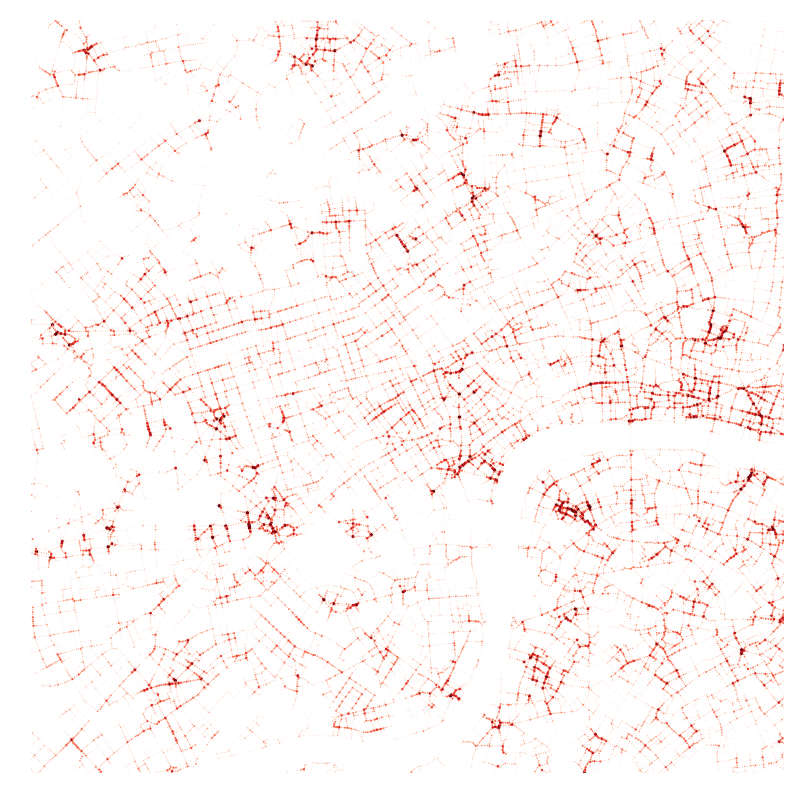


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 702.16m
    Beta: 0.0020000000949949026 (spatial impedance factor)
    Max walking tolerance: 500m
    


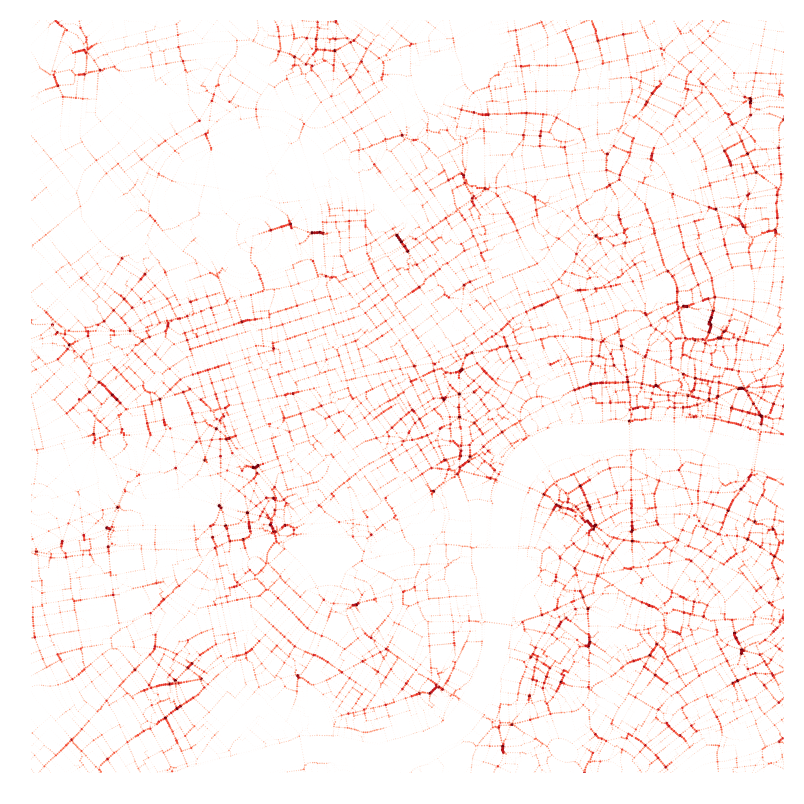


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 702.16m
    Beta: 0.0020000000949949026 (spatial impedance factor)
    Max walking tolerance: 2000m
    


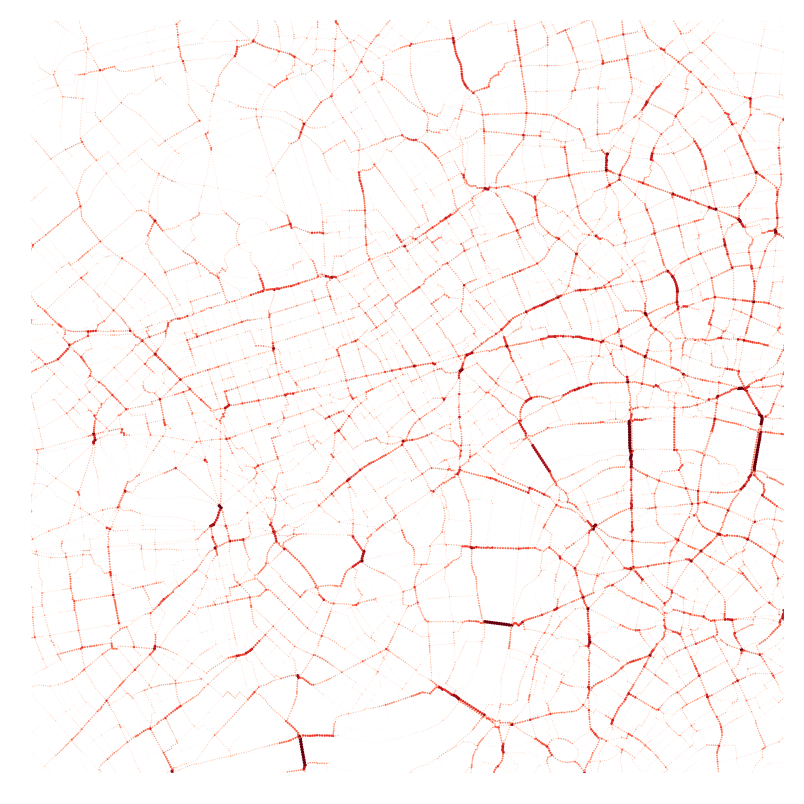

In [6]:
for d in [250, 500, 2000]:
    b = networks.beta_from_distance(d)[0]
    avg_d = networks.avg_distance_for_beta(float(b))[0]
    print(
        f"""
    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b} (spatial impedance factor)
    Max walking tolerance: {d}m
    """
    )
    simple_plot(network_structure.nodes.xs, network_structure.nodes.ys, nodes_gdf[f"cc_metric_node_beta_{d}"])

for d in [250, 500, 2000]:
    print(
        f"""
    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b} (spatial impedance factor)
    Max walking tolerance: {d}m
    """
    )
    simple_plot(network_structure.nodes.xs, network_structure.nodes.ys, nodes_gdf[f"cc_metric_node_betweenness_{d}"])